### Classificação de Textos em Sites de Notícias sobre Finanças

O seguinte experimento tem como objetivo realizar a classificação de textos para os diferentes tópicos que o site www.sunoresearch.com.br atribui às suas publicações. Os dados foram obtidos com a implementação do crawler, que também está disponibilizada neste repositório.

**Objetivos Principais:**

- Importação dos dados textuais do portal Suno
- Importação dos GloVe Embeddings criados
- Realizar o preprocessamento dos dados textuais
- Implementar a rede LSTM e testar diferentes combinações de hiperparâmetros
- Comparar os resultados de classificação em dois cenários:
    - Somente com o título das notícias (coluna 'title')
    - Somente com o texto completo das notícias (coluna 'full_text')

In [1]:
import os
import re
import json
import string
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import np_utils

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

from sklearn import metrics

from sklearn import preprocessing

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

---

### 1) Importação dos Dados Textuais

In [2]:
json_data_path = '../crawlers/suno/data/results-full-suno-2020.json'

with open(json_data_path, 'r', encoding='utf8') as json_file:
    data = json.load(json_file)

df_suno = pd.DataFrame(data)

In [3]:
# Convert date to datetime format
df_suno['date'] = pd.to_datetime(df_suno['date'], format='%d/%m/%Y %H:%M')

# Set date column as index
df_suno.set_index('date', inplace=True)

# Order by date
df_suno.sort_index(inplace=True)

In [4]:
df_suno.sample(5)

,topic,title,full_text,url,tags
date,,,,,
2020-02-19 09:52:00,Mercado,"Dólar abre em alta e bate R$ 4,37; greve dos c...",O dólar abriu em alta nesta quarta-feira (19)....,https://www.sunoresearch.com.br/noticias/dolar...,"[Banco Central, câmbio flutuante, coronavírus,..."
2020-11-30 17:35:00,Negócios,Azul (AZUL4) antecipa fim de acordo de redução...,A companhia aérea Azul (AZUL4) informou nesta ...,https://www.sunoresearch.com.br/noticias/azul-...,"[Azul, AZUL4, pandemia]"
2020-01-10 20:59:00,Negócios,Airbus tem alta na produção e pode superar Boe...,"A Airbus anunciou, nesta sexta-feira (10), que...",https://www.sunoresearch.com.br/noticias/airbu...,"[737 max, Airbus, Boeing]"
2020-12-13 14:38:00,Negócios,BR Rating lançará formas de avaliação ESG para...,"A BR Rating, primeira agência brasileira de ra...",https://www.sunoresearch.com.br/noticias/br-ra...,"[BR Rating, ESG, rating]"
2020-11-16 07:26:00,Internacional,"Produção industrial da China cresce 6,9% em ou...","A produção industrial da China cresceu 6,9% em...",https://www.sunoresearch.com.br/noticias/produ...,"[China, coronavírus, Economia, produção indust..."


In [5]:
df_suno['title'] = df_suno['title'].astype('string')
df_suno['full_text'] = df_suno['full_text'].astype('string')

In [6]:
df_suno.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19344 entries, 2018-08-28 11:12:00 to 2021-01-02 16:36:00
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   topic      19344 non-null  object
 1   title      19344 non-null  string
 2   full_text  19344 non-null  string
 3   url        19344 non-null  object
 4   tags       19344 non-null  object
dtypes: object(3), string(2)
memory usage: 906.8+ KB


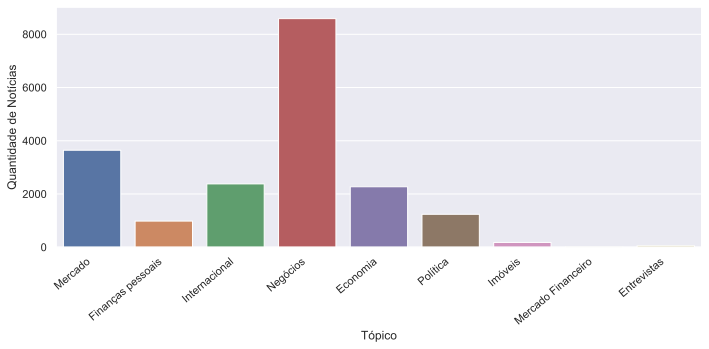

In [7]:
sns.set(style='darkgrid')

plt.figure(figsize=(10, 5))

ax = sns.countplot(df_suno['topic'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.ylabel('Quantidade de Notícias')
plt.xlabel('Tópico')

plt.tight_layout()
plt.show()

In [8]:
# Extract main columns
df_suno = df_suno[['title', 'full_text', 'topic']]

In [9]:
# Select main topics
df_suno = df_suno[df_suno['topic'].isin(['Mercado', 'Economia', 'Internacional', 'Negócios'])]

In [10]:
df_suno.sample(5)

,title,full_text,topic
date,,,
2019-08-15 08:42:00,Oi tem queda nas receitas e eleva o prejuízo a...,A Oi (OIBR3) voltou a apresentar queda nas rec...,Negócios
2019-03-14 14:29:00,"Morgan Stanley compra 14,5% da Somos Educação,...",O Morgan Stanley anunciou na noite da última q...,Negócios
2019-09-16 20:02:00,"Vendas do varejo crescem 2,3% em agosto, apont...",A Cielo divulgou nesta segunda-feira (16) o Ín...,Economia
2020-04-30 18:32:00,Ações em alta: mercados nos EUA têm melhor abr...,As ações dos EUA terminaram abril como o melho...,Internacional
2018-10-30 11:30:00,Embraer tem prejuízo de mais de 80 milhões de ...,Em balanço divulgado na manhã desta terça-feir...,Negócios


---

#### 2) Preprocessamento dos Dados

In [11]:
def remove_emojis(sentence):

    "Remoção de Emojis nas mensagens de texto."

    # Padrões dos Emojis
    emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', sentence)

def remove_valores(sentence):
    new_sentece = ''
    
    for token in sentence.split():
        if token.isdigit():
            token = '<NUM>'
        new_sentece += ' {}'.format(token)
        
    return new_sentece

In [12]:
# 1. Aplicar preprocessamento nos títulos e textos completos

# Substituir símbolos importantes
df_suno['title'] = df_suno['title'].map(lambda s: s.replace('-feira', ''))
df_suno['title'] = df_suno['title'].map(lambda s: s.replace('+', 'mais '))
df_suno['title'] = df_suno['title'].map(lambda s: s.replace('-', 'menos '))
df_suno['title'] = df_suno['title'].map(lambda s: s.replace('%', ' por cento'))
df_suno['title'] = df_suno['title'].map(lambda s: s.replace('R$', ''))
df_suno['title'] = df_suno['title'].map(lambda s: s.replace('U$', ''))
df_suno['title'] = df_suno['title'].map(lambda s: s.replace('US$', ''))
df_suno['title'] = df_suno['title'].map(lambda s: s.replace('S&P 500', 'spx'))

df_suno['full_text'] = df_suno['full_text'].map(lambda s: s.replace('-feira', ''))
df_suno['full_text'] = df_suno['full_text'].map(lambda s: s.replace('+', 'mais '))
df_suno['full_text'] = df_suno['full_text'].map(lambda s: s.replace('-', 'menos '))
df_suno['full_text'] = df_suno['full_text'].map(lambda s: s.replace('%', ' por cento'))
df_suno['full_text'] = df_suno['full_text'].map(lambda s: s.replace('R$', ''))
df_suno['full_text'] = df_suno['full_text'].map(lambda s: s.replace('U$', ''))
df_suno['full_text'] = df_suno['full_text'].map(lambda s: s.replace('US$', ''))
df_suno['full_text'] = df_suno['full_text'].map(lambda s: s.replace('S&P 500', 'spx'))

# Transformar em String e Letras Minúsculas nas Mensagens
df_suno['title'] = df_suno['title'].map(lambda s: str(s).lower())
df_suno['full_text'] = df_suno['full_text'].map(lambda s: str(s).lower())

# Remover Pontuações
df_suno['title'] = df_suno['title'].map(lambda s: s.translate(str.maketrans('', '', string.punctuation)))
df_suno['full_text'] = df_suno['full_text'].map(lambda s: s.translate(str.maketrans('', '', string.punctuation)))

# Remover Emojis     
df_suno['title'] = df_suno['title'].map(lambda s: remove_emojis(s))
df_suno['full_text'] = df_suno['full_text'].map(lambda s: remove_emojis(s))

# Quebras de Linha desnecessárias
df_suno['title'] = df_suno['title'].map(lambda s: s.replace('\n', ' '))
df_suno['full_text'] = df_suno['full_text'].map(lambda s: s.replace('\n', ' '))

# Remover aspas duplas
df_suno['title'] = df_suno['title'].map(lambda s: s.replace('\"', ''))
df_suno['title'] = df_suno['title'].map(lambda s: s.replace('“', ''))
df_suno['title'] = df_suno['title'].map(lambda s: s.replace('”', ''))

df_suno['full_text'] = df_suno['full_text'].map(lambda s: s.replace('\"', ''))
df_suno['full_text'] = df_suno['full_text'].map(lambda s: s.replace('“', ''))
df_suno['full_text'] = df_suno['full_text'].map(lambda s: s.replace('”', ''))

# Remover valores
df_suno['title'] = df_suno['title'].map(lambda s: remove_valores(s))
df_suno['full_text'] = df_suno['full_text'].map(lambda s: remove_valores(s))

# Espaços desnecessários
df_suno['title'] = df_suno['title'].map(lambda s: s.strip())
df_suno['full_text'] = df_suno['full_text'].map(lambda s: s.strip())

In [13]:
samples = df_suno['title'].values
print (samples[:5])
print (type(samples[0]))

['alta do dólar e paralisia do ibovespa são resultado de negociação do nafta e incerteza sobre o stf'
 'índice spx quebra recorde abrindo acima de <NUM> pela primeira vez'
 'distribuição de dividendos da csn é bloqueada pela justiça'
 'investida agressiva de acionista preocupa gafisa'
 'marfrig anuncia política de limite de alavancagem']
<class 'str'>


In [14]:
# Transformar os tópicos em números inteiros
label_encoder = preprocessing.LabelEncoder()
df_suno['topic_number'] = label_encoder.fit_transform(df_suno['topic'])
class_names = label_encoder.classes_

In [15]:
labels = df_suno['topic_number'].values
print (labels[:5])

[2 1 3 3 3]


In [16]:
# Shuffle the data
seed = 1337
rng = np.random.RandomState(seed)
rng.shuffle(samples)
rng = np.random.RandomState(seed)
rng.shuffle(labels)

# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(samples))
train_samples = samples[:-num_validation_samples]
val_samples = samples[-num_validation_samples:]
train_labels = labels[:-num_validation_samples]
val_labels = labels[-num_validation_samples:]

In [17]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

MAX_SEQUENCE_LENGTH = 200

vectorizer = TextVectorization(max_tokens=20000, 
                               output_sequence_length=MAX_SEQUENCE_LENGTH,
                               output_mode='int',
                               dtype=tf.string)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(32)
vectorizer.adapt(text_ds)

In [18]:
vectorizer.get_vocabulary()[:5]

[b'de', b'num', b'em', b'por', b'cento']

In [19]:
output = vectorizer([["o índice bovespa caiu hoje"]])
output.numpy()[0, :6]

array([  25,  437, 3126, 1239,  588,    0], dtype=int64)

In [20]:
voc = [w.decode('utf-8') for w in vectorizer.get_vocabulary()]
word_index = dict(zip(voc, range(len(voc))))

In [21]:
test = ["o", "índice", "bovespa", "caiu", "hoje"]
[word_index[w] for w in test]

[23, 435, 3124, 1237, 586]

In [22]:
path_to_glove_file = "../../data/full_text_financial_news_vectors.txt"

embeddings_index = {}
with open(path_to_glove_file, encoding='utf8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 149078 word vectors.


In [23]:
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 9492 words (226 misses)


In [24]:
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)

---

#### 3) Modelo LSTM

In [25]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

# This callback will stop the training when there is no improvement in  
# the validation loss for five consecutive epochs.  
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
#                                             mode='min', 
#                                             verbose=1, 
#                                             patience=10)

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(embedded_sequences)
x = tf.keras.layers.Dropout(0.8450298764739911)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.6108763092812357)(x)
preds = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model = keras.Model(int_sequences_input, preds)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         2916000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          85248     
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0     

In [26]:
# Compile and Fit
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [ ]:
print ('Training LSTM model...')

lstm = model.fit(x_train,
                 y_train,
                 batch_size=32,
                 epochs=15,
                 validation_split=0.2)

Training LSTM model...
Epoch 1/15


In [ ]:
# Loss / Iteration
plt.plot(lstm.history['loss'], label='Loss')
plt.plot(lstm.history['val_loss'], label='Val_Loss')
plt.legend()
plt.show()

In [ ]:
# Accuracy / Iteration
plt.plot(lstm.history['accuracy'], label='Accuracy')
plt.plot(lstm.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.show()

In [ ]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model(x)
end_to_end_model = keras.Model(string_input, preds)

title_example = 'petrobras petr4 reabre plano de demissão voluntária'

probabilities = end_to_end_model.predict(
    [[title_example]]
)

print ("Title Example: '{}'".format(title_example))
print ('Predicted Class: {}'.format(class_names[np.argmax(probabilities[0])]))
print ('Probabilities: {}'.format(probabilities[0]))

In [ ]:
predicted = model.predict(x_val)

Y_predicted = np.argmax(predicted, axis=1)

print(metrics.classification_report(y_val, Y_predicted, target_names=class_names))
print('Acurácia: {}'.format(metrics.accuracy_score(y_val, Y_predicted)))

---